# Library

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.base import clone
import sys
sys.path.append("../src")
from myproject.pipelines.preprocessing_pipeline import preprocessing_pipeline
from myproject.pipelines.clean_pipeline import cleaning_pipeline
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
    confusion_matrix
)
import optuna
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

import xgboost as xgboost
import numpy as np
import joblib


mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("credit_classification_ml")

<Experiment: artifact_location='mlflow-artifacts:/454137213308002966', creation_time=1764624674955, experiment_id='454137213308002966', last_update_time=1764624674955, lifecycle_stage='active', name='credit_classification_ml', tags={'mlflow.experimentKind': 'custom_model_development'}>

# DATA

In [7]:
#Load DataFrame
df = pd.read_csv("/home/jakub/Pulpit/Credit Classification ML/data/raw/train.csv")

/tmp/ipykernel_72341/3561941609.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/jakub/Pulpit/Credit Classification ML/data/raw/train.csv")


In [8]:
# Encode categorical label y
label_encoder = LabelEncoder()
df['Credit_Score_LE'] = label_encoder.fit_transform(df['Credit_Score'])
class_map = dict(enumerate(label_encoder.classes_))
print("Class mapping: ",class_map)

Class mapping:  {0: 'Good', 1: 'Poor', 2: 'Standard'}


In [9]:
#Split data to X and y
X = df.drop(columns=["Credit_Score_LE", "Credit_Score"])
y = df["Credit_Score_LE"]

print("X shape:", X.shape)
print("y shape:", y.shape)

#Split to train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Load cleaning and preprocessing function
clean = cleaning_pipeline()
preprocess = preprocessing_pipeline()

X shape: (100000, 27)
y shape: (100000,)


# Model Baseline

In [10]:
#Building baseline model pipeline 
xgb_base = Pipeline([
    ("clean", clean),
    ("prep", preprocess),
    ("xgb_base", XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42,
        n_jobs=4
    ))
])

In [11]:
#Split data to 5 folds for cross val
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Scoring metrics for model evaluation 
scoring = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro"
}

#Cross Validate
cv_result_base = cross_validate(
    xgb_base,
    X_train, y_train,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

#Metrics for cross validate

#Mean
cv_base_metrics_mean = {
    f"cv_{metrics}_mean_base": float(cv_result_base[f"test_{metrics}"].mean())
    for metrics in scoring.keys()
}

#Std
cv_base_metrics_std = {
    f"cv_{metrics}_std_base": float(cv_result_base[f"test_{metrics}"].std())
    for metrics in scoring.keys()
}

#Combine metrics together
cv_base_metrics = {**cv_base_metrics_mean, **cv_base_metrics_std}
pd.DataFrame([cv_base_metrics])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warni

,cv_accuracy_mean_base,cv_balanced_accuracy_mean_base,cv_f1_macro_mean_base,cv_precision_macro_mean_base,cv_recall_macro_mean_base,cv_accuracy_std_base,cv_balanced_accuracy_std_base,cv_f1_macro_std_base,cv_precision_macro_std_base,cv_recall_macro_std_base
0,0.751163,0.73296,0.733775,0.734797,0.73296,0.00369,0.004004,0.003932,0.003959,0.004004


In [12]:
#Fitting model to X_train i y_train
xgb_base.fit(X_train, y_train)


#Make predictions on X_test
y_pred_base = xgb_base.predict(X_test)

#Metrics for final evaluation
test_metrics_base = {
    "test_accuracy": accuracy_score(y_test, y_pred_base),
    "test_balanced_accuracy": balanced_accuracy_score(y_test, y_pred_base),
    "test_f1_macro": f1_score(y_test, y_pred_base, average="macro"),
    "test_precision_macro": precision_score(y_test, y_pred_base, average="macro"),
    "test_recall_macro": recall_score(y_test, y_pred_base, average="macro"),
}

pd.DataFrame([test_metrics_base])

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,test_accuracy,test_balanced_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.75215,0.733413,0.734942,0.736746,0.733413


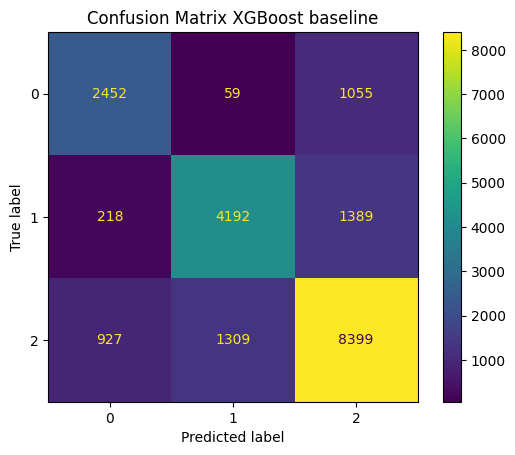

In [13]:
#Confusion Matrix 
cm = confusion_matrix(y_test, y_pred_base)
matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot()
plt.title("Confusion Matrix XGBoost baseline")
plt.show()

In [14]:
# #Log scores to mlflow
# with mlflow.start_run(run_name="XGBoost_baseline"):
#     mlflow.log_metrics(cv_base_metrics)
#     mlflow.log_metrics(test_metrics_base)

# Optuna

In [15]:
def objective(trial):
    #Function for creating new clean model with hyperparameters for Optuna
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
    }
    
    #Make model
    xgb = XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=42,
        **params 
    )
    
    #Pipeline for preproces data
    pipe = Pipeline([
        ("clean",cleaning_pipeline()),
        ("prep", preprocessing_pipeline()),
        ("xgb", xgb)
    ])
    
    
    #Split data to 3 folds
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    
    
    """Learning process"""
    # Split X_train,y_train into fold-specific training and validation sets
    for tr_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        #Training pipeline   
        pipe.fit( X_tr, y_tr,)
    
        #Prediction on validation set
        y_val_pred = pipe.predict(X_val)
    
        #F1_macro metrics
        score = f1_score(y_val, y_val_pred, average="macro")
        scores.append(score)
    
    return float(np.mean(scores))
    

In [16]:
#Search the best params with Optuna 
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

[I 2025-12-07 17:44:28,762] A new study created in memory with name: no-name-69b489af-1d3a-49bd-9629-405160915afd
  0%|          | 0/20 [00:00<?, ?it/s]/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, e

[I 2025-12-07 17:44:45,150] Trial 0 finished with value: 0.7230787408566282 and parameters: {'n_estimators': 624, 'max_depth': 7, 'learning_rate': 0.26379106109801853, 'min_child_weight': 8, 'subsample': 0.7174547884837003, 'colsample_bytree': 0.90903630995671, 'gamma': 1.9451716191684159, 'reg_lambda': 4.891048169221517}. Best is trial 0 with value: 0.7230787408566282.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 0. Best value: 0.723079:  10%|█         | 2/20 [00:36<0

[I 2025-12-07 17:45:05,236] Trial 1 finished with value: 0.6976272846176054 and parameters: {'n_estimators': 957, 'max_depth': 4, 'learning_rate': 0.040391303969093954, 'min_child_weight': 2, 'subsample': 0.771008304256134, 'colsample_bytree': 0.739430043301636, 'gamma': 1.6827061280597584, 'reg_lambda': 1.8177543639605105}. Best is trial 0 with value: 0.7230787408566282.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 0. Best value: 0.723079:  15%|█▌        | 3/20 [01:00<0

[I 2025-12-07 17:45:29,262] Trial 2 finished with value: 0.6964136317530262 and parameters: {'n_estimators': 1099, 'max_depth': 4, 'learning_rate': 0.0237657931491223, 'min_child_weight': 6, 'subsample': 0.6093533381549681, 'colsample_bytree': 0.7074787231712327, 'gamma': 0.7707390302596739, 'reg_lambda': 1.844474931849086}. Best is trial 0 with value: 0.7230787408566282.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 0. Best value: 0.723079:  20%|██        | 4/20 [01:31<0

[I 2025-12-07 17:46:00,039] Trial 3 finished with value: 0.7145613523785611 and parameters: {'n_estimators': 808, 'max_depth': 8, 'learning_rate': 0.011097102916648548, 'min_child_weight': 6, 'subsample': 0.6608919268817641, 'colsample_bytree': 0.8567145612583114, 'gamma': 1.1663039911472206, 'reg_lambda': 3.1369518619365913}. Best is trial 0 with value: 0.7230787408566282.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 0. Best value: 0.723079:  25%|██▌       | 5/20 [01:40<0

[I 2025-12-07 17:46:09,412] Trial 4 finished with value: 0.6843864392945379 and parameters: {'n_estimators': 349, 'max_depth': 5, 'learning_rate': 0.18197987616284808, 'min_child_weight': 8, 'subsample': 0.802372699209891, 'colsample_bytree': 0.8238331985329318, 'gamma': 4.439249116129109, 'reg_lambda': 1.8579744511397394}. Best is trial 0 with value: 0.7230787408566282.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 5. Best value: 0.724604:  30%|███       | 6/20 [01:53<0

[I 2025-12-07 17:46:21,863] Trial 5 finished with value: 0.7246038690706867 and parameters: {'n_estimators': 634, 'max_depth': 6, 'learning_rate': 0.20077906688669925, 'min_child_weight': 8, 'subsample': 0.7839965266547799, 'colsample_bytree': 0.6973376310164239, 'gamma': 1.47101943811158, 'reg_lambda': 4.284364004508258}. Best is trial 5 with value: 0.7246038690706867.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 5. Best value: 0.724604:  35%|███▌      | 7/20 [02:05<0

[I 2025-12-07 17:46:34,524] Trial 6 finished with value: 0.6923749482485371 and parameters: {'n_estimators': 308, 'max_depth': 6, 'learning_rate': 0.024364364675195434, 'min_child_weight': 9, 'subsample': 0.7520753278054264, 'colsample_bytree': 0.9314036877996618, 'gamma': 0.07448212722247549, 'reg_lambda': 0.8709413753054052}. Best is trial 5 with value: 0.7246038690706867.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 5. Best value: 0.724604:  40%|████      | 8/20 [02:29<0

[I 2025-12-07 17:46:58,698] Trial 7 finished with value: 0.696807479576164 and parameters: {'n_estimators': 1468, 'max_depth': 7, 'learning_rate': 0.03071844264870934, 'min_child_weight': 5, 'subsample': 0.6227279701789329, 'colsample_bytree': 0.8837895839426049, 'gamma': 3.53507384164018, 'reg_lambda': 4.843439719762708}. Best is trial 5 with value: 0.7246038690706867.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 5. Best value: 0.724604:  45%|████▌     | 9/20 [02:49<0

[I 2025-12-07 17:47:18,128] Trial 8 finished with value: 0.6943193925166717 and parameters: {'n_estimators': 1435, 'max_depth': 8, 'learning_rate': 0.03885399213318474, 'min_child_weight': 9, 'subsample': 0.863373506039427, 'colsample_bytree': 0.6600965602231076, 'gamma': 4.361617636232681, 'reg_lambda': 0.57354691316996}. Best is trial 5 with value: 0.7246038690706867.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 5. Best value: 0.724604:  50%|█████     | 10/20 [03:00<

[I 2025-12-07 17:47:29,686] Trial 9 finished with value: 0.676429339221659 and parameters: {'n_estimators': 334, 'max_depth': 4, 'learning_rate': 0.011244076529240046, 'min_child_weight': 2, 'subsample': 0.6625353083368483, 'colsample_bytree': 0.79260222313947, 'gamma': 4.713229777299421, 'reg_lambda': 1.4231509086748906}. Best is trial 5 with value: 0.7246038690706867.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 5. Best value: 0.724604:  55%|█████▌    | 11/20 [03:13<

[I 2025-12-07 17:47:41,820] Trial 10 finished with value: 0.6784702302001113 and parameters: {'n_estimators': 649, 'max_depth': 3, 'learning_rate': 0.10844482723017404, 'min_child_weight': 10, 'subsample': 0.988337834007307, 'colsample_bytree': 0.6021701050742216, 'gamma': 2.8628174022648207, 'reg_lambda': 3.599255421290944}. Best is trial 5 with value: 0.7246038690706867.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 5. Best value: 0.724604:  60%|██████    | 12/20 [03:24<

[I 2025-12-07 17:47:53,690] Trial 11 finished with value: 0.7061996451135361 and parameters: {'n_estimators': 588, 'max_depth': 6, 'learning_rate': 0.27210228485880794, 'min_child_weight': 7, 'subsample': 0.8571175229092924, 'colsample_bytree': 0.9883913124705198, 'gamma': 2.1470431434090775, 'reg_lambda': 4.9269842669211945}. Best is trial 5 with value: 0.7246038690706867.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 5. Best value: 0.724604:  65%|██████▌   | 13/20 [03:41<

[I 2025-12-07 17:48:09,881] Trial 12 finished with value: 0.7044647277784405 and parameters: {'n_estimators': 599, 'max_depth': 7, 'learning_rate': 0.09545872933083369, 'min_child_weight': 4, 'subsample': 0.7181330257402894, 'colsample_bytree': 0.7651388075123289, 'gamma': 2.8167384850478876, 'reg_lambda': 4.002701626758874}. Best is trial 5 with value: 0.7246038690706867.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 5. Best value: 0.724604:  70%|███████   | 14/20 [03:55<

[I 2025-12-07 17:48:24,344] Trial 13 finished with value: 0.7219843997355321 and parameters: {'n_estimators': 812, 'max_depth': 7, 'learning_rate': 0.2415047114897114, 'min_child_weight': 8, 'subsample': 0.8344469511806609, 'colsample_bytree': 0.9187193134526345, 'gamma': 1.7356497013656158, 'reg_lambda': 4.219458479473445}. Best is trial 5 with value: 0.7246038690706867.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 5. Best value: 0.724604:  75%|███████▌  | 15/20 [04:09<

[I 2025-12-07 17:48:37,795] Trial 14 finished with value: 0.7203663686608683 and parameters: {'n_estimators': 540, 'max_depth': 6, 'learning_rate': 0.13254592843268623, 'min_child_weight': 10, 'subsample': 0.9125986458119411, 'colsample_bytree': 0.6675069178784484, 'gamma': 0.9797046818946887, 'reg_lambda': 2.8923606765682237}. Best is trial 5 with value: 0.7246038690706867.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 5. Best value: 0.724604:  80%|████████  | 16/20 [04:33<

[I 2025-12-07 17:49:01,817] Trial 15 finished with value: 0.6918723038079603 and parameters: {'n_estimators': 1085, 'max_depth': 5, 'learning_rate': 0.06816242808526572, 'min_child_weight': 7, 'subsample': 0.7106266900235686, 'colsample_bytree': 0.9886106476906589, 'gamma': 3.4134906093600916, 'reg_lambda': 4.256221323314751}. Best is trial 5 with value: 0.7246038690706867.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 16. Best value: 0.759268:  85%|████████▌ | 17/20 [04:53

[I 2025-12-07 17:49:22,051] Trial 16 finished with value: 0.7592681353870447 and parameters: {'n_estimators': 475, 'max_depth': 7, 'learning_rate': 0.1681606210516921, 'min_child_weight': 4, 'subsample': 0.7121228472314867, 'colsample_bytree': 0.6110450413274902, 'gamma': 0.3175830084219089, 'reg_lambda': 4.985388907768303}. Best is trial 16 with value: 0.7592681353870447.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 17. Best value: 0.767641:  90%|█████████ | 18/20 [05:15

[I 2025-12-07 17:49:44,419] Trial 17 finished with value: 0.7676410881001265 and parameters: {'n_estimators': 468, 'max_depth': 8, 'learning_rate': 0.17187119087494718, 'min_child_weight': 4, 'subsample': 0.9149115456982565, 'colsample_bytree': 0.6013158673066127, 'gamma': 0.022747391056113897, 'reg_lambda': 3.53153465151639}. Best is trial 17 with value: 0.7676410881001265.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 17. Best value: 0.767641:  95%|█████████▌| 19/20 [05:39

[I 2025-12-07 17:50:08,642] Trial 18 finished with value: 0.7569214201246489 and parameters: {'n_estimators': 452, 'max_depth': 8, 'learning_rate': 0.06930766218379956, 'min_child_weight': 4, 'subsample': 0.9478619446196229, 'colsample_bytree': 0.6015415749616876, 'gamma': 0.04736221124006951, 'reg_lambda': 2.593467486809467}. Best is trial 17 with value: 0.7676410881001265.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 17. Best value: 0.767641: 100%|██████████| 20/20 [05:56

[I 2025-12-07 17:50:25,232] Trial 19 finished with value: 0.7572274793794217 and parameters: {'n_estimators': 444, 'max_depth': 8, 'learning_rate': 0.1470082897242034, 'min_child_weight': 1, 'subsample': 0.8977413209853626, 'colsample_bytree': 0.6327118586160405, 'gamma': 0.45594442158387555, 'reg_lambda': 3.3713333189708443}. Best is trial 17 with value: 0.7676410881001265.


In [17]:
print(study.best_value)
print(study.best_params)
hparams= study.best_params


0.7676410881001265
{'n_estimators': 468, 'max_depth': 8, 'learning_rate': 0.17187119087494718, 'min_child_weight': 4, 'subsample': 0.9149115456982565, 'colsample_bytree': 0.6013158673066127, 'gamma': 0.022747391056113897, 'reg_lambda': 3.53153465151639}


# Early stopping

In [18]:
#Split data for ES
X_tr_es, X_val_es, y_tr_es, y_val_es = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

#Pipeline for preprocessing data
pipe_no_model = Pipeline([
    ("clean", cleaning_pipeline()),
    ("prep", preprocessing_pipeline())
])

pipe_no_model.fit(X_tr_es, y_tr_es)
X_tr_clean = pipe_no_model.transform(X_tr_es)
X_val_clean = pipe_no_model.transform(X_val_es)

#Copy best params from Optuna
best_params = study.best_trial.params.copy()

#Create new model with best hyperparameters
xgb_es = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    n_jobs=4,
    random_state=42,
    **best_params,
)
        
#Pipeline for fit early stopping
xgb_es.fit(
    X_tr_clean,
    y_tr_es,
    eval_set=[(X_val_clean, y_val_es)],
    early_stopping_rounds=50,
    verbose=False
)

#Save best iteration
best_iter = xgb_es.best_iteration
print("best_iteration: ", best_iter)

#change number of nestimators
best_params["n_estimators"] = best_iter

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


best_iteration:  466


# Final Model

In [19]:
xgb_final = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    n_jobs=4,
    random_state=42,
    **best_params,

)

final_pipe = Pipeline([
    ("clean", cleaning_pipeline()),
    ("prep", preprocessing_pipeline()),
    ("xgb", xgb_final),
])

final_pipe.fit(X_train, y_train)

# train
y_train_pred = final_pipe.predict(X_train)
f1_train = f1_score(y_train, y_train_pred, average="macro")
print("TRAIN F1-macro:", f1_train)

#Final predict on X_test
y_pred_final = final_pipe.predict(X_test)

#Metrics for mlflow
test_metrics_xgb = {
    "test_accuracy": accuracy_score(y_test, y_pred_final),
    "test_balanced_accuracy": balanced_accuracy_score(y_test, y_pred_final),
    "test_f1_macro": f1_score(y_test, y_pred_final, average="macro"),
    "test_precision_macro": precision_score(y_test, y_pred_final, average="macro"),
    "test_recall_macro": recall_score(y_test, y_pred_final, average="macro"),
}
pd.DataFrame([test_metrics_xgb])


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


TRAIN F1-macro: 0.9823797741757364


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,test_accuracy,test_balanced_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.7981,0.78584,0.787567,0.789443,0.78584


In [20]:
# #Final log paramas and metric to mlflow
# with mlflow.start_run(run_name="XGBoost_tuned"):
#     mlflow.log_params(hparams)
#     mlflow.log_metrics(test_metrics_xgb)

In [22]:
#Saving the model
joblib.dump(final_pipe, "/home/jakub/Pulpit/Credit Classification ML/models/xgboost_final_classification.pkl")

['/home/jakub/Pulpit/Credit Classification ML/models/xgboost_final_classification.pkl']